<a href="https://colab.research.google.com/github/Ovocode05/NeuroDeff/blob/main/LTNE_rel5_Scratch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from matplotlib import cm
import os

In [2]:
class selfAdaptiveActivation(nn.Module):
  def __init__(self, activation_type="tanh"):
    super().__init__()
    self.activation_type = activation_type.lower()

    #learnable slope parameter
    self.alpha = nn.Parameter(torch.tensor(1.0))


    if self.activation_type not in ["tanh", "swish", "sin"]:
      raise ValueError(f"Unsupported activation type: {activation_type}")

  def forward(self, x):
    alpha_clamped = torch.clamp(self.alpha, 0.01, 10.0)
    scaled_x = x* alpha_clamped
    if self.activation_type == "tanh":
      return torch.tanh(scaled_x)
    elif self.activation_type == "swish":
      return scaled_x * torch.sigmoid(scaled_x)
    else :
      return torch.sin(scaled_x)

In [3]:
class SA_PINN(nn.Module):
  def __init__(self, layers, neurons, activation="tanh"):
    super(SA_PINN, self).__init__()

    self.activation_type = activation.lower()
    self.act_fn = selfAdaptiveActivation(self.activation_type)

    net_layers = [nn.Linear(1, neurons)]

    for _ in range(layers - 1):
      net_layers.append(nn.Linear(neurons, neurons))
      net_layers.append(selfAdaptiveActivation(self.activation_type))

    net_layers.append(nn.Linear(neurons, 2))  # Two outputs: T_f, T_s
    self.net = nn.Sequential(*net_layers)

  def forward(self, x):
        return self.net(x)

In [ ]:
# class PINN(nn.Module):
#     def __init__(self, layers, neurons, activation='tanh'):
#         super(PINN, self).__init__()

#         # Map from string to actual nn.Module activation
#         activation_map = {
#             "tanh": nn.Tanh(),
#             "relu": nn.ReLU(),
#             "sigmoid": nn.Sigmoid(),
#             "swish":nn.SiLU(),  # Swish ≈ SiLU in PyTorch
#             "gelu": nn.GELU(),
#             "elu": nn.ELU(),
#         }

#         if activation.lower() not in activation_map:
#             raise ValueError(f"Unsupported activation '{activation}'. Choose from: {list(activation_map.keys())}")

#         act_fn = activation_map[activation.lower()]
#         net_layers = [nn.Linear(1, neurons)]
#         for _ in range(layers - 1):
#             net_layers.append(nn.Linear(neurons, neurons))
#             net_layers.append(act_fn)

#         net_layers.append(nn.Linear(neurons, 2))  # Two outputs: T_f, T_s
#         self.net = nn.Sequential(*net_layers)

#     def forward(self, x):
#         return self.net(x)

In [4]:
def gradients(T, x, order=1):
    if order == 1:
        grad = torch.autograd.grad(
            T, x,
            grad_outputs=torch.ones_like(T),
            create_graph=True,
            retain_graph=True,
            allow_unused=True  # Important for debugging
        )[0]
        if grad is None:
            raise RuntimeError("First derivative returned None. Check if x has requires_grad=True and is used.")
        return grad

    elif order == 2:
        T_x = gradients(T, x, order=1)
        if T_x is None:
            raise RuntimeError("First derivative for second-order grad is None.")
        grad2 = torch.autograd.grad(
            T_x, x,
            grad_outputs=torch.ones_like(T_x),
            create_graph=True,
            retain_graph=True,
            allow_unused=True,
            order=1
        )[0]
        if grad2 is None:
            raise RuntimeError("Second derivative returned None.")
        return grad2


In [5]:
def chebyshev_points(n):
    i = torch.arange(n).float()
    x = 0.5 * (1 - torch.cos((np.pi * i) / (n - 1)))
    return x.view(-1, 1)

In [6]:
def get_collocation_points(n_domain=300, n_bc=100):
    x_domain = chebyshev_points(n_domain) #more points near boundary area
    x_bc_left = torch.zeros(n_bc, 1)
    x_bc_right = torch.ones(n_bc, 1)

    x_domain.requires_grad_()
    x_bc_left.requires_grad_()
    x_bc_right.requires_grad_()

    return x_domain, x_bc_left, x_bc_right

In [7]:
def residual_loss(x_domain:torch.Tensor, model, config:dict):
  # Ensure x_domain requires gradients for differentiation
  x_domain.requires_grad_()
  output = model(x_domain)
  T_f = output[:, 0:1]
  T_s = output[:, 1:2]

  T_f_n = gradients(T_f, x_domain, order=1)
  T_f_nn = gradients(T_f_n, x_domain, order=1) # Calculate second derivative from the first derivative
  T_s_n = gradients(T_s, x_domain, order=1)
  T_s_nn = gradients(T_s_n, x_domain, order=1) # Calculate second derivative from the first derivative

  # Dynamic parameter handling
  def get_param(name):
        val = config["physics"][name]
        if name in config["physics"]["varying_params"]:
            if callable(val):
                # Convert numpy array output from callable to tensor
                return torch.tensor(val(x_domain), dtype=x_domain.dtype, device=x_domain.device).view(-1, 1)
            elif isinstance(val, (list, np.ndarray)):
                 # Convert list/numpy array to tensor
                return torch.tensor(val, dtype=x_domain.dtype, device=x_domain.device).view(-1, 1)
        # Ensure non-varying parameters are tensors if needed, or handled appropriately
        if not isinstance(val, torch.Tensor):
             return torch.tensor(val, dtype=x_domain.dtype, device=x_domain.device)
        return val


  eps = get_param('eps')
  k = get_param('k')
  delta = get_param('delta')
  beta = get_param('beta')
  Bi = get_param('Bi')

  eqn1 = (eps * k * (1 + delta * T_f) * T_f_nn +
            eps * k * delta * (T_f_n**2) +
            Bi * (T_s - T_f) - 1 - beta)

  eqn2 = ((1 - eps) * (1 + delta * T_s) * T_s_nn +
            (1 - eps) * delta * (T_s_n**2) -
            Bi * (T_s - T_f) + beta)

  loss_eqn = torch.mean(eqn1**2) + torch.mean(eqn2**2)
  return loss_eqn

In [8]:
def boundary_loss(model, x_left, x_right):
    # Ensure boundary points require gradients
    x_left.requires_grad_(True)
    x_right.requires_grad_(True)

    out_left = model(x_left)
    out_right = model(x_right)

    T_f_right = out_right[:, 0:1]
    T_s_right = out_right[:, 1:2]

    T_f_n_left = gradients(out_left[:, 0:1], x_left)
    T_s_n_left = gradients(out_left[:, 1:2], x_left)

    loss_bc = (
        torch.mean((T_f_right - 0)**2) +
        torch.mean((T_s_right - 0)**2) +
        torch.mean((T_f_n_left - 0)**2) +
        torch.mean((T_s_n_left - 0)**2)
    )
    return loss_bc

In [9]:
def relation_dict(x:np.ndarray, ) -> dict:
  RELATIONS = {
      "relation_2_a" : {
            "network": { "neurons":256, "layers":3},  # Same as before
            "training": {"activation":"swish", "lr":0.001,
                         "lose_weights": [50,100],
                         "epochs1":3000, "display_every":1000, "epochs2":6000 },
            "physics": {
                "eps": 0.1,
                "k": 25,
                "delta": -0.2,
                "beta": [0,5,10,15,20],
                "Bi": [ lambda x_tensor: 100*(np.sin(np.pi * x_tensor.detach().numpy() *2)**2)],
                "varying_params": ["Bi", "beta"]  # Specify which params vary
            },
      },
      "relation_2_b" : {
            "network": { "neurons":256, "layers":3},  # Same as before
            "training": {"activation":"swish", "lr":0.001,
                         "lose_weights": [50, 100],
                         "epochs1":3000, "display_every":1000, "epochs2":5000  },
            "physics": {
                "eps": 0.1,
                "k": 25,
                "delta": -0.2,
                "beta": [0,5,10,15,20],
                "Bi": [lambda x_tensor: 50 *(1-x_tensor.detach().numpy()**2)],
                "varying_params": ["Bi", "beta"]  # Specify which params vary
            },
      },
  }
  return RELATIONS

In [10]:
class EarlyStopping:
    def __init__(self, patience=1000, min_delta=1e-6):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.should_stop = False

    def __call__(self, current_loss):
        if current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True


In [11]:
def resample_points_by_residual(model, config, total_domain=300, top_k=100):
    x_fine = chebyshev_points(total_domain)
    x_fine.requires_grad_()
    residual1 = residual_loss(x_fine, model, config).detach().cpu().numpy().flatten()
    residual2 = boundary_loss(model, x_fine[:50], x_fine[-50:]).detach().cpu().numpy().flatten()
    residuals = residual1 + residual2

    top_indices = np.argsort(residuals)[-top_k:]
    x_high_residual = x_fine[top_indices]
    x_random = x_fine[np.random.choice(len(x_fine), total_domain - top_k, replace=False)]

    x_new = torch.cat([x_high_residual, x_random], dim=0)
    x_new.requires_grad_()
    return x_new


In [12]:
def train_pinn(config:dict, pre_trainied_path:str = None):
  #create the model
  model = SA_PINN(config["network"]["layers"], config["network"]["neurons"], activation=config["training"]["activation"])

  #loading the weights
  if pre_trainied_path is not None:
    print(f"Loading pretrained weights from {pre_trainied_path}")
    model.load_state_dict(torch.load(pre_trainied_path))

  #setup optimizers and configs
  adam = torch.optim.Adam(model.parameters(), lr=config["training"]["lr"])
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adam, 'min', factor=0.5, patience=200)
  w_pde, w_bc = config["training"]["lose_weights"]
  # early_stopper = EarlyStopping(patience=2000, min_delta=1e-5)

  x_domain, x_bc_left, x_bc_right = get_collocation_points()

  for epoch in range(config["training"]["epochs1"]):
    adam.zero_grad()

    loss_pde = residual_loss(x_domain, model, config)
    loss_bc = boundary_loss(model, x_bc_left, x_bc_right)
    loss = w_pde*loss_pde + w_bc*loss_bc

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    loss.backward(retain_graph=True)
    adam.step()
    scheduler.step(loss)

    if epoch % config["training"]["display_every"] == 0 and epoch>0:
        print(f"Epoch {epoch}: Loss = {loss.item():.5e}  (PDE: {loss_pde.item():.2e}, BC: {loss_bc.item():.2e})")
        x_domain = resample_points_by_residual(model, config)

    # early_stopper(loss.item())
    # if early_stopper.should_stop:
    #         print(f"Early stopping at epoch {epoch}")
    #         break

  print("Starting L-BFGS refinement...")
  lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=500)

  def closure():
        lbfgs.zero_grad()
        loss_pde = residual_loss(x_domain, model, config)
        loss_bc = boundary_loss(model, x_bc_left, x_bc_right)
        loss = w_pde * loss_pde + w_bc * loss_bc
        loss.backward(retain_graph=True)
        return loss

  lbfgs.step(closure)

  print("L-BFGS refinement complete.")

  print("Starting Adam refinement...")
  early_stopper2 = EarlyStopping(patience=3000, min_delta=1e-5)
  adam2 = torch.optim.AdamW(model.parameters(), lr=config["training"]["lr"])
  scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(adam2, 'min', factor=0.5, patience=200)

  for epoch in range(config["training"]["epochs2"]):
    adam2.zero_grad()
    loss_pde2 = residual_loss(x_domain, model, config)
    loss_bc2 = boundary_loss(model, x_bc_left, x_bc_right)
    loss2 = w_pde * loss_pde2 + w_bc * loss_bc2

    loss2.backward(retain_graph=True)
    adam2.step()
    scheduler2.step(loss2)

    if torch.isnan(loss2):
      print("NaN Detected in Loss")
      print(f"loss_pde: {loss_pde2}, loss_bc: {loss_bc2}")
      print(model.parameters())
      raise ValueError("NaN in training")

    if epoch % config["training"]["display_every"] == 0 and epoch>0:
        print(f"Epoch {epoch}: Loss = {loss2.item():.5e}  (PDE: {loss_pde2.item():.2e}, BC: {loss_bc2.item():.2e})")

    early_stopper2(loss2.item())
    if early_stopper2.should_stop:
            print(f"Early stopping at epoch {epoch}")
            break

  print("Adamw completed")

  return model

In [13]:
def predict_temperatures(model, x_test)->dict:
  model.eval()
  with torch.no_grad():
    T_pred = model(x_test)
  return T_pred

In [14]:
from collections import defaultdict
def run_relation(param:str, n: np.ndarray) -> dict:
    config = relation_dict(n)[param]
    results_predict = {}
    # Prepare parameter combinations for other relations
    varying_params = config["physics"]["varying_params"]
    param_values = [
        config["physics"][p] if isinstance(config["physics"][p], (list, np.ndarray)) else [config["physics"][p]]
         for p in varying_params
      ]

    for combo in product(*param_values):
        param_str = "_".join(f"{p}={v}" for p,v in zip(varying_params, combo))
        print(f"\nTraining {param} with {param_str}") #help to track which combo is being trained
        #we make a new config for every combo
        current_physics = config["physics"].copy()

        for i, p in enumerate(varying_params):
             v = combo[i]
             if isinstance(current_physics[p], list) or isinstance(current_physics[p], np.ndarray):
                 # If the original parameter was a list/array, we use the value from the combo directly
                 current_physics[p] = v
             elif callable(current_physics[p]):
                 # If the original parameter was a callable function, we keep it as is
                 current_physics[p] = v

        current_config = {
           "network": config["network"],
           "training": config["training"],
           "physics": current_physics
         }
        model = train_pinn(current_config)

        T_pred = predict_temperatures(model, n)
        results_predict[param_str] = {
           "x": torch.flatten(n),
           "T_f": T_pred[:, 0:1],
           "T_s": T_pred[:, 1:2],
           "params": dict(zip(varying_params, combo))
           }

    return results_predict

In [15]:
def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [16]:
from collections import defaultdict
def plot_grouped_by_Bi(results, title_prefix="PINN Prediction Grouped by Bi", save_dir="Result01"):
    ensure_dir(save_dir)
    """
    For each unique Bi (from result key), plot all (Tf, Ts) curves for that Bi in one figure.
    """
    grouped = defaultdict(dict)
    for key, res in results.items():
        # Parse key like "Bi=<func>_delta=0.4"
        bi_key = [kv for kv in key.split('_') if kv.startswith("Bi=")][0]
        grouped[bi_key][key] = res

    # Step 2: Plot each Bi group in its own figure
    for bi_label, group in grouped.items():
        plt.figure(figsize=(10, 6))
        colors = plt.cm.tab10.colors

        for i, (label, res) in enumerate(group.items()):
            x = res["x"]
            T_f = res["T_f"].flatten()
            T_s = res["T_s"].flatten()
            color = colors[i % len(colors)]

            plt.plot(x, T_s, color=color, linestyle='-', label=f"{label} - T_s")
            plt.plot(x, T_f, color=color, linestyle='--', label=f"{label} - T_f")

        plt.xlabel("x")
        plt.ylabel("Temperature")
        plt.title(f"{title_prefix}: {bi_label}")
        plt.legend(fontsize="small")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        #save
        fig_path = os.path.join(save_dir, f"01_{bi_label}.png")
        plt.savefig(fig_path)
        plt.close()



Training relation_2_a with Bi=<function relation_dict.<locals>.<lambda> at 0x7cf9a9f5d120>_beta=0
Epoch 1000: Loss = 2.79305e+00  (PDE: 5.56e-02, BC: 1.21e-04)
Epoch 2000: Loss = 1.33322e+00  (PDE: 2.36e-02, BC: 1.51e-03)
Starting L-BFGS refinement...
L-BFGS refinement complete.
Starting Adam refinement...
Epoch 1000: Loss = 2.41602e-01  (PDE: 4.46e-03, BC: 1.87e-04)
Epoch 2000: Loss = 2.35255e-01  (PDE: 4.34e-03, BC: 1.83e-04)
Epoch 3000: Loss = 2.35059e-01  (PDE: 4.33e-03, BC: 1.83e-04)
Early stopping at epoch 3000
Adamw completed

Training relation_2_a with Bi=<function relation_dict.<locals>.<lambda> at 0x7cf9a9f5d120>_beta=5
Epoch 1000: Loss = 2.77853e+00  (PDE: 4.59e-02, BC: 4.82e-03)
Epoch 2000: Loss = 3.95246e-01  (PDE: 7.66e-03, BC: 1.23e-04)
Starting L-BFGS refinement...
L-BFGS refinement complete.
Starting Adam refinement...
Epoch 1000: Loss = 3.52855e-01  (PDE: 6.53e-03, BC: 2.62e-04)
Epoch 2000: Loss = 3.13493e-01  (PDE: 5.78e-03, BC: 2.46e-04)
Epoch 3000: Loss = 3.11666e

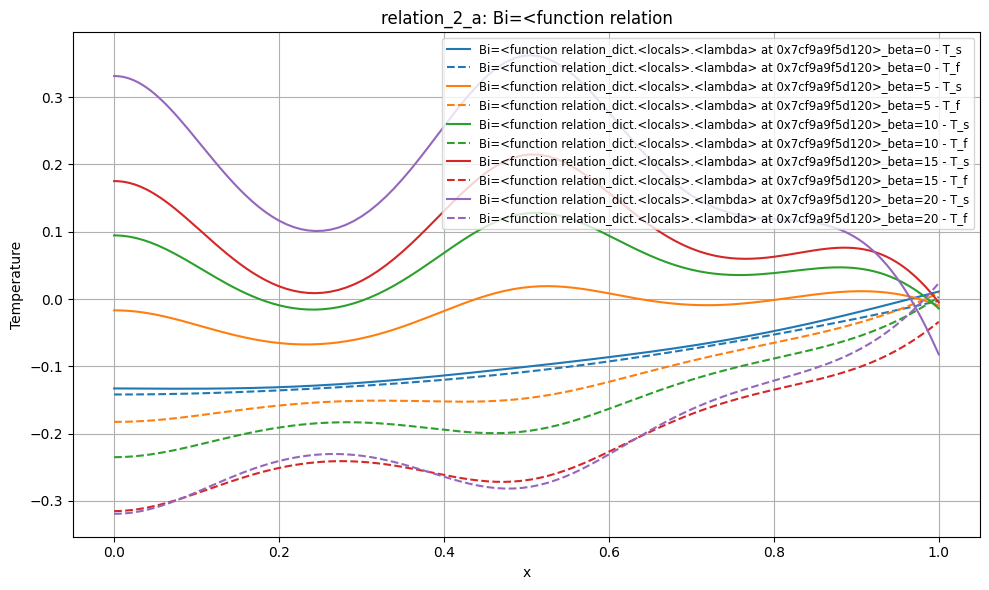

In [17]:
n = chebyshev_points(150)
all_results = {}

for param in [ "relation_2_a"]:
    all_results[param] = run_relation(param, n)
    plot_grouped_by_Bi(all_results[param], param)

